In [1]:
import numpy as np
from copy import deepcopy
import dionysus as dio
import scipy
import scipy.linalg
import pandas as pd
import gudhi as gd
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt


from Laplacian_Functions_torch import *
from plot_complex import draw_2d_simplicial_complex, draw_filtration

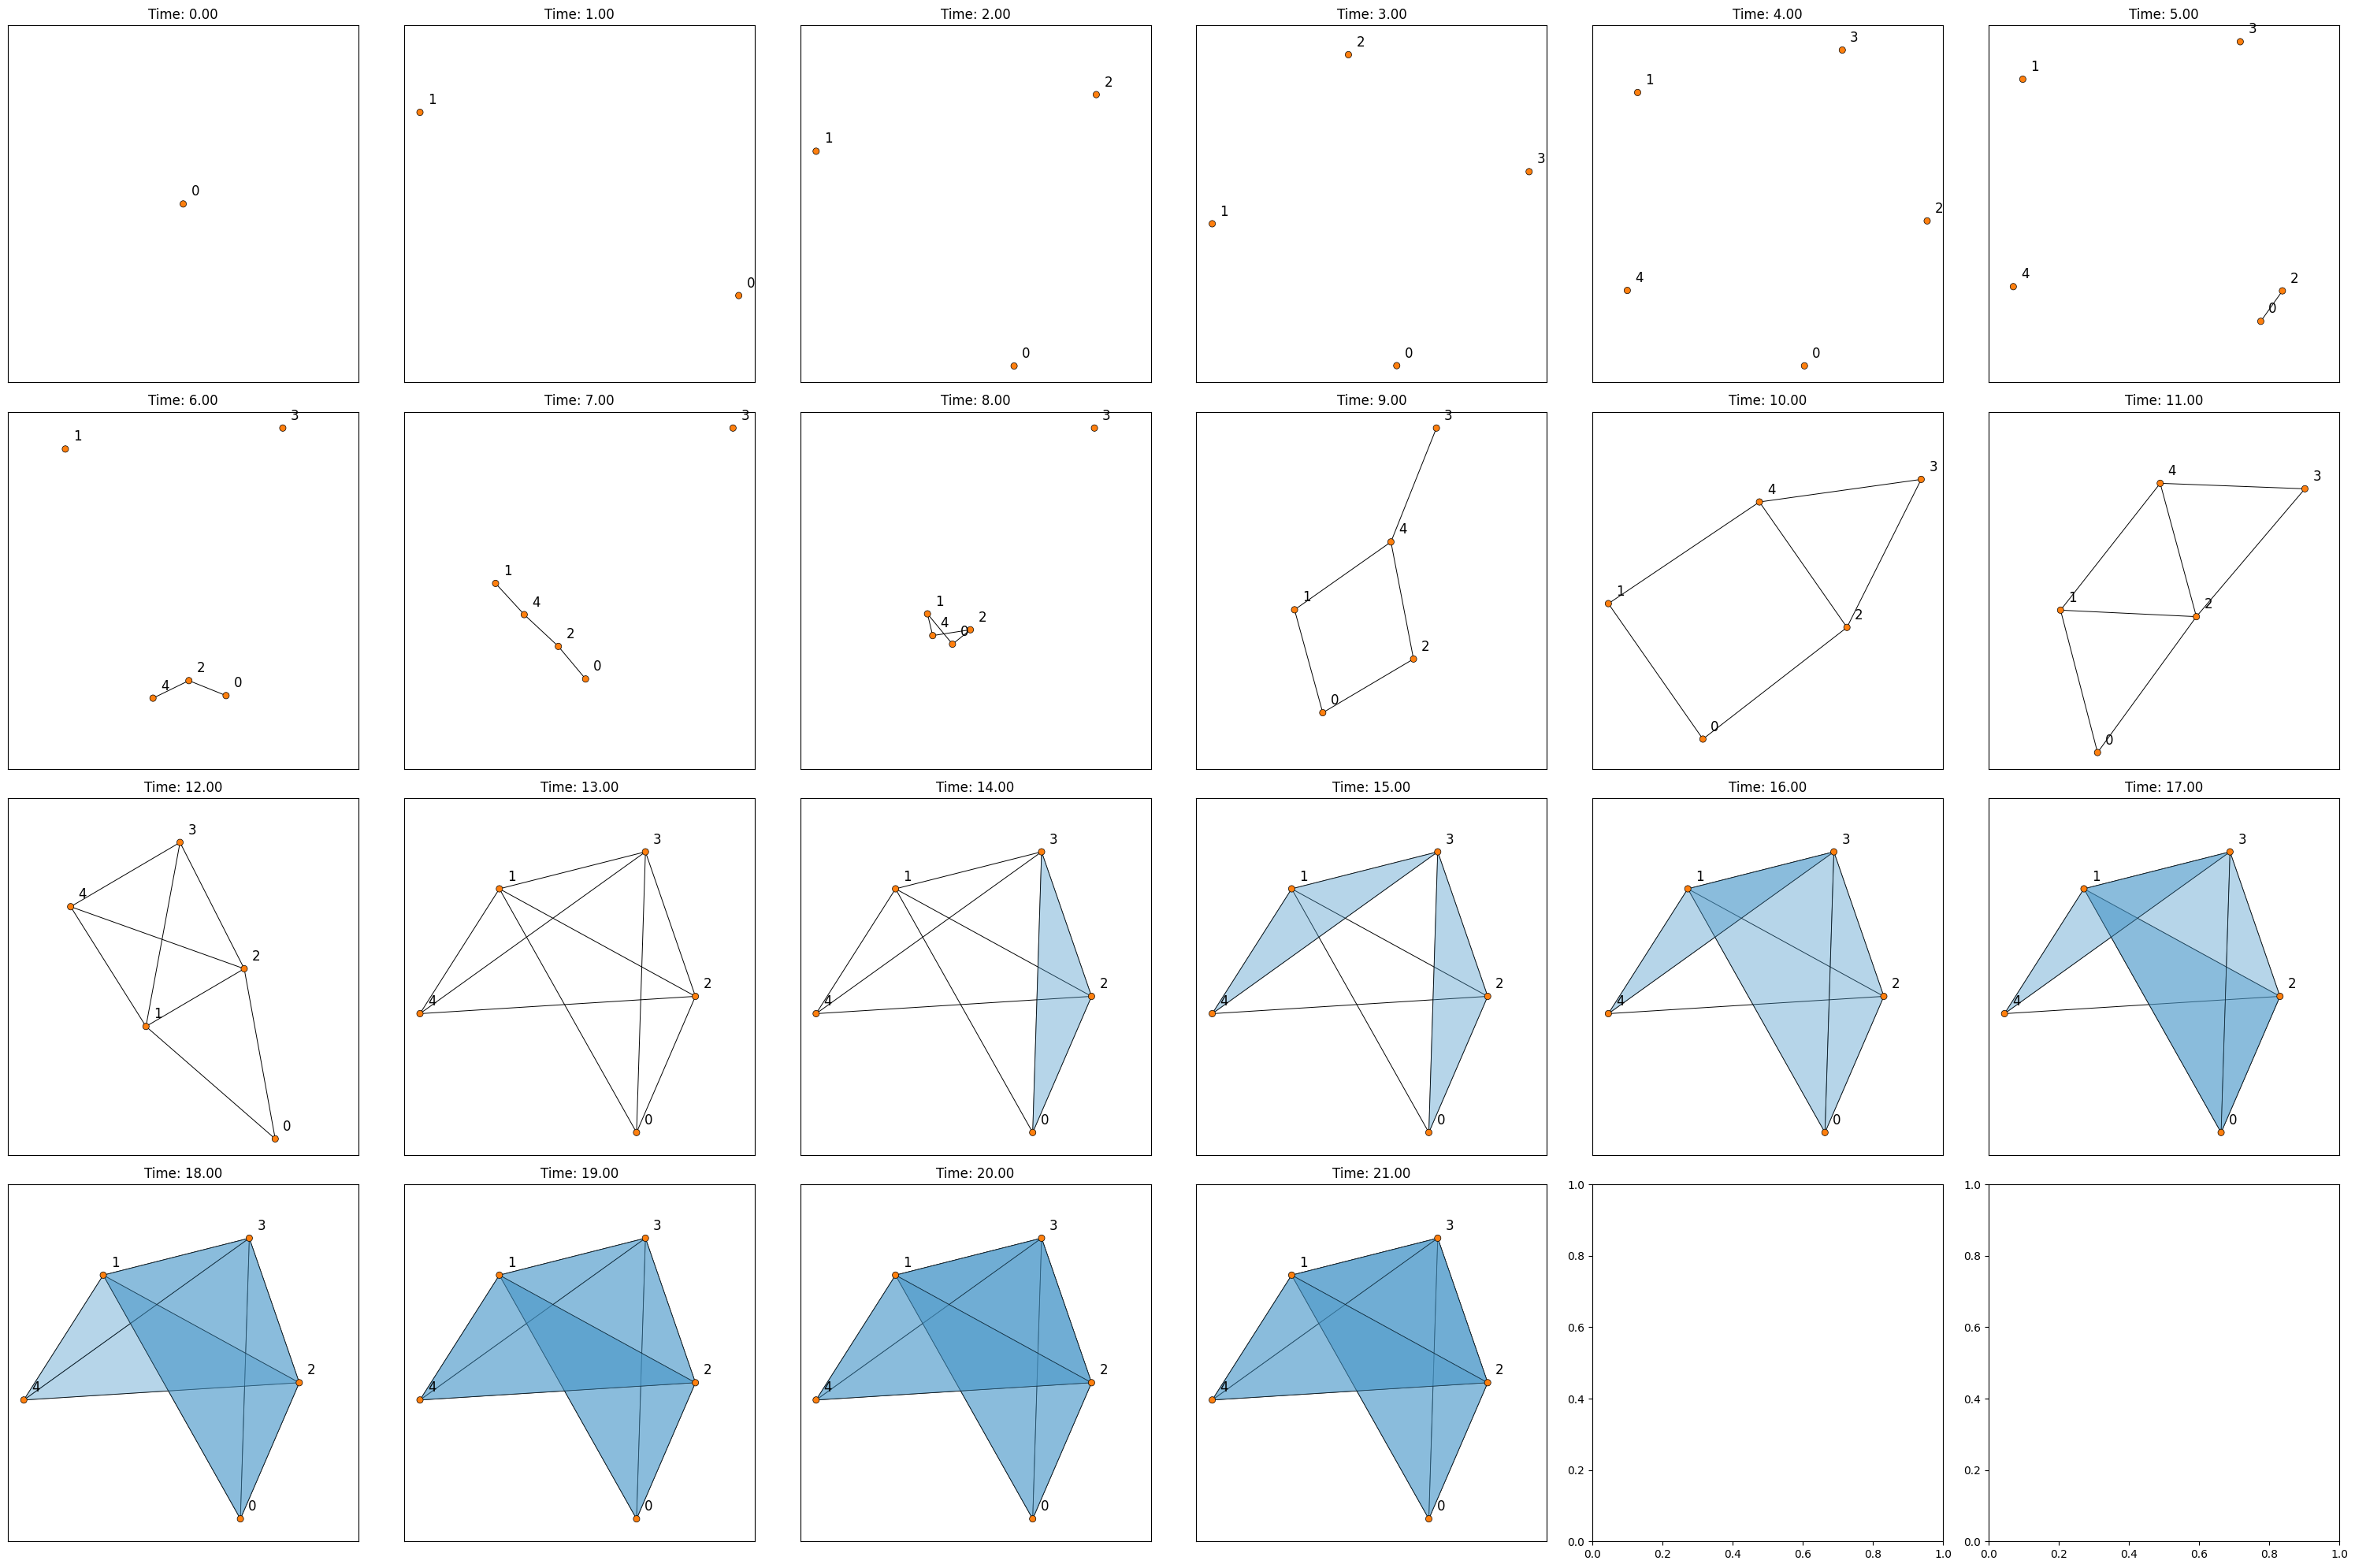

In [2]:
from venv import create


def create_cycle(n, overlap = 0, start_n=0, overlap_start = 0):
    simplices = []
    for v_i in range(n):
        if v_i < overlap:
            simplices.append(([v_i+overlap_start], 0))
            if v_i + 1 == overlap:
                simplices.append(([v_i+overlap_start, start_n], 1))
            else:
                simplices.append(([v_i+overlap_start, v_i+overlap_start+1], 1))
        elif v_i < n-1:
            simplices.append(([v_i+start_n-overlap], 0))
            simplices.append(([v_i+start_n-overlap, v_i+1+start_n-overlap], 1))
        else:
            simplices.append(([v_i+start_n-overlap], 0))
            # If you started with overlap, go to overlap_start. Otherwise go to start_n.
            simplices.append(([v_i+start_n-overlap, start_n*(overlap==0)+overlap_start*(overlap > 0)], 1))
    return simplices
    
def create_path(n, end_path = -1):
    if end_path < 0:
        end_path += n+1
    simplices = [([0], 0), ([end_path], 1)]
    for i in range(1,n):
        if i < end_path:
            simplices.append(([i], len(simplices)))
        else:
            simplices.append(([i+1], len(simplices)))
    for i in range(end_path-1):
        simplices.append(([i, i+1], len(simplices)))
    for i in range(end_path, n):
        simplices.append(([i, i+1], len(simplices)))
    simplices.append(([end_path-1, end_path], len(simplices)))
    return simplices
    

# Drawn
simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([2,3], 7), ([0,2], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([2,3], 5), ([4], 6), ([2,4], 7), ([3,4], 8), ([2,3,4], 9), ([0,3], 10), ([1,3], 11), ([0,2], 12), ([0,1,3], 13)]#, ([0,2,3], 10)]

# Swapped 7 and 8
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([0,2], 7), ([2,3], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]

# "Flipped"
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped d and e
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([2,3], 7), ([1,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped b and c
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([0,2], 5), ([1,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# swapped 2 and 3
# simplices = [([0], 0), ([1], 1),  ([3], 2), ([2], 3),([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# Non equidistant time intervals
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 8), ([1,3], 10), ([2,3], 10.1), ([0,2], 12), ([0,1,3], 12.5)]

# Ren paper
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,2], 1), ([0,3], 1), ([2,3], 1), ([0,1], 2), ([0,2,3], 3)]

# Drawn new
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 1), ([0,1], 2), ([1,2], 2), ([2,3], 2), ([0,2], 3), ([0,3], 3), ([4], 4), ([2,4], 5), ([3,4], 5), ([0,1,2], 6), ([2,3,4], 7), ([0,2,3], 8)]

# Test easy
# simplices = [([0], 0), ([1], 0), ([2], 0), ([0,1], 0), ([0,2], 0), ([1,2], 0),
#              ([3], 1), ([2,3], 1), ([1,3], 1), ([0,1,2], 1), ([1,2,3], 1)]

# Test hard
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,1], 0), ([0,2], 0), ([1,3], 0), ([2,3], 0),
#               ([1,2], 1),  ([0,1,2], 1), ([1,2,3], 1)]

# Example PowerPoint
# simplices = [([0],0), ([1], 0), ([2], 1), ([3], 1), ([4], 1), ([0,2], 1), ([2,3], 1), ([2,4], 1), ([3,4], 1), ([1,4], 1)]

# Dimension 2 feature
# simplices = [([0],0), ([1], 1), ([0,1], 1), ([2], 2), ([0,2], 2), ([1,2], 2), ([3], 3), ([0,3], 3), ([1,3], 3), ([2,3], 3), ([0,2,3], 4), ([1,2,3], 5), ([0,1,2], 6), ([0,1,3], 7)]

# 2 dimension 2 features
simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([4], 4), ([0,2], 5), 
             ([2,4], 6), ([1,4], 7), ([0,1], 8), ([3,4], 9), ([2,3], 10), ([1,2], 11), 
             ([1,3], 12), ([0,3], 13), ([0,2,3], 14), ([1,3,4], 15), ([0,1,3], 16), ([0,1,2], 17),
             ([2,3,4], 18), ([1,2,4], 19), ([1,2,3], 20), ([0,1,2,3], 21)]

# Fewer timesteps
# simplices = [([0], 0), ([1], 0), ([2], 2), ([3], 2), ([4], 4), ([0,2], 4), 
#              ([2,4], 6), ([1,4], 6), ([0,1], 8), ([3,4], 8), ([2,3], 10), ([1,2], 10), 
#              ([1,3], 12), ([0,3], 12), ([0,2,3], 14), ([1,3,4], 14), ([0,1,3], 16), ([0,1,2], 16),
#              ([2,3,4], 18), ([1,2,4], 18), ([1,2,3], 20), ([0,1,2,3], 20)]

# NOT 2 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 2), ([0,2], 4), ([0,1], 4),  ([1,2], 3)]

# 2 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 1), ([1,2], 3), ([0,1], 2), ([0,2], 3)]

# 3 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 1), ([3], 1), ([0,3], 2), ([0,1], 2), ([1,2], 2), ([2,3], 2)]

# simplices = [([0], 0), ([3], 1), ([6], 1), ([1], 2), ([0,1], 2), ([4], 2), ([3,4], 2), ([7], 2), ([6,7], 2.5), ([2], 3), ([5], 3), ([8], 3), ([1,2], 3), ([2,3], 4), ([4,5], 4), ([5,6], 4), ([7,8], 4), ([0,8], 4)]

# Path
# simplices = create_path(8, end_path=-1)

# Cycles
# simplices = create_cycle(3)
x = 4
y = 4
z = 4
x4 = 5
overlap = 3
# Three cycles added in order x->y->z, with x and z not connected.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap, overlap_start=x-overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap, overlap_start=x+y-2*overlap)
# Three cycles added with all of them connecting on overlap vertices.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)+ create_cycle(x4, start_n=x+y+z-2*overlap, overlap=overlap)
# simplices.append(([7], 0))
# simplices.append(([6,7], 1))
# simplices = create_cycle(7)
# simplices.append(([10], 2))
# simplices.append(([0,2], 2))
# simplices.append(([0,1,2], 2))
# simplices.append(([0,3], 3))
# simplices.append(([0,2,3], 3))
# print(simplices)

f = dio.Filtration()
for vertices, time in simplices:
    f.append(dio.Simplex(vertices, time))

draw_filtration(f)

# Drawing graph
# G = nx.Graph()
# f.sort()
# for s in f:
#     if s.dimension() == 0:
#         G.add_node(s[0])
#     elif s.dimension() == 1:
#         G.add_edge(s[0], s[1])
# nx.draw_planar(G, with_labels=True)

Computing boundary matrices:   0%|          | 0/22 [00:00<?, ?it/s]

Computing boundary matrices done.


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

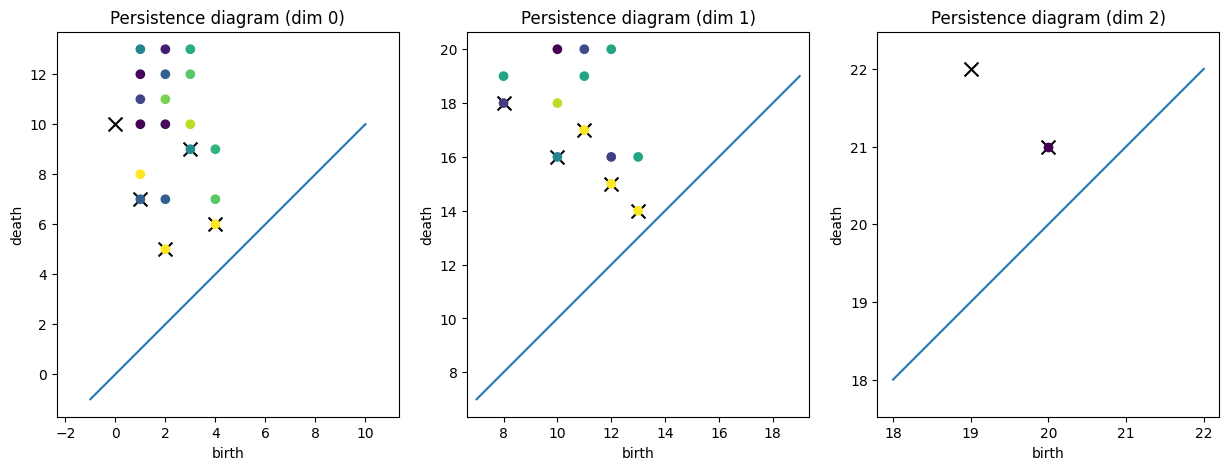

ValueError: not enough values to unpack (expected 4, got 2)

In [3]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st
    # return B22_stm1@B22_sm1t-B22_st

    # Normal
    # return -1*(B22_sm1tm1 - B22_sm1t - B22_stm1 + B22_st)

    # return B22_sm1t - B22_st
    
eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, max_dim =2, plot_diagram= True, plot_types=["Min", "Max", "Sum", "Amount of"], Laplacian_fun= Laplacian_fun, method="less_memory", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, integer_time_steps=True)

(0.0, 10.0)

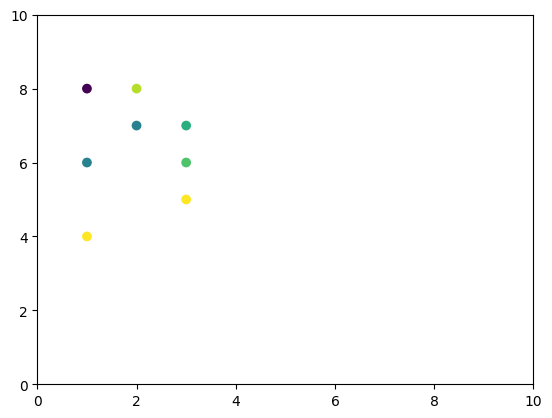

In [16]:
s_list = []
t_list = []
cmap = []
for s in eigenvalues[0].keys():
    for t in eigenvalues[0][s].keys():
        if np.sum(eigenvalues[0][s][t]) > 1e-10:
            s_list.append(s)
            t_list.append(t)
            cmap.append(np.sum(eigenvalues[0][s][t]))

plt.scatter(s_list, t_list, c=cmap)
plt.xlim(0,10)
plt.ylim(0,10)

In [61]:
def plot_diagram(f, eigenvalues, show=False, max_dim=2,
                 line_style=None, pt_style_normal=None,
                 limits = None):
    """
    Plot the persistence diagram.

    Arguments:
        dgm (Diagram): See for example `init_diagrams`.

    Keyword Arguments:
        show (bool): Display the plot. (Default: False)
        labels (bool): Set axis labels. (Default: False)
        ax (AxesSubplot): Axes that should be used for plotting (Default: None)
        pt_style (dict): argments passed to `ax.scatter` for style of points.
        line_style (dict): argments passed to `ax.plot` for style of diagonal line.
    """

    p = dio.cohomology_persistence(f, 47, True)
    dgms = dio.init_diagrams(p, f)
    fig, ax = plt.subplots(1, 3, figsize=(5*(max_dim+1),5))

    for q, dgm in enumerate(dgms):

        line_kwargs = {}
        pt_kwargs = {"c": "black", "marker": "x", "alpha": 0.5, "s": 100}
        if pt_style_normal is not None:
            pt_kwargs.update(pt_style_normal)
        if line_style is not None:
            line_kwargs.update(line_style)


        inf = float('inf')
        min_birth,max_birth,min_death,max_death = inf,-1,inf,-1
        if not limits:
            min_birth = min(min_birth, min((p.birth for p in dgm if p.birth != inf), default=0)-1)
            max_birth = max(max_birth, max((p.birth for p in dgm if p.birth != inf), default=1)+1)
            min_death = min(min_death, min((p.death for p in dgm if p.death != inf), default=min_birth)-1)
            max_death = max(max_death, max((p.death for p in dgm if p.death != inf), default=max_birth)+1)
        else:
            min_birth, max_birth, min_death, max_death = limits

        if ax[q] is None:
            ax[q] = plt.axes()
        ax[q].set_aspect('equal', 'datalim')

        min_diag = min(min_birth, min_death)
        max_diag = max(max_birth, max_death)
        ax[q].scatter([p.birth for p in dgm], [p.death if p.death != inf else max_death for p in dgm], **pt_kwargs)
        ax[q].plot([min_diag, max_diag], [min_diag, max_diag], **line_kwargs)

        s_list = []
        t_list = []
        cmap = []
        for s in eigenvalues[q].keys():
            for t in eigenvalues[q][s].keys():
                if np.sum(eigenvalues[q][s][t]) > 1e-10:
                    s_list.append(s)
                    t_list.append(t)
                    cmap.append(np.sum(eigenvalues[q][s][t]))

        if q == 0:
            print([p.birth for p in dgm])
            print(s_list)
        ax[q].scatter(s_list, t_list, c=cmap)

        ax[q].set_xlabel('birth')
        ax[q].set_ylabel('death')
        ax[q].set_title(f"Persistence diagram (dim {q})")

        ## clip the view
        #plt.axes().set_xlim([min_birth, max_birth])
        #plt.axes().set_ylim([min_death, max_death])

    if show:
        plt.show()


[0.0, 1.0, 2.0, 3.0]
[1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0]


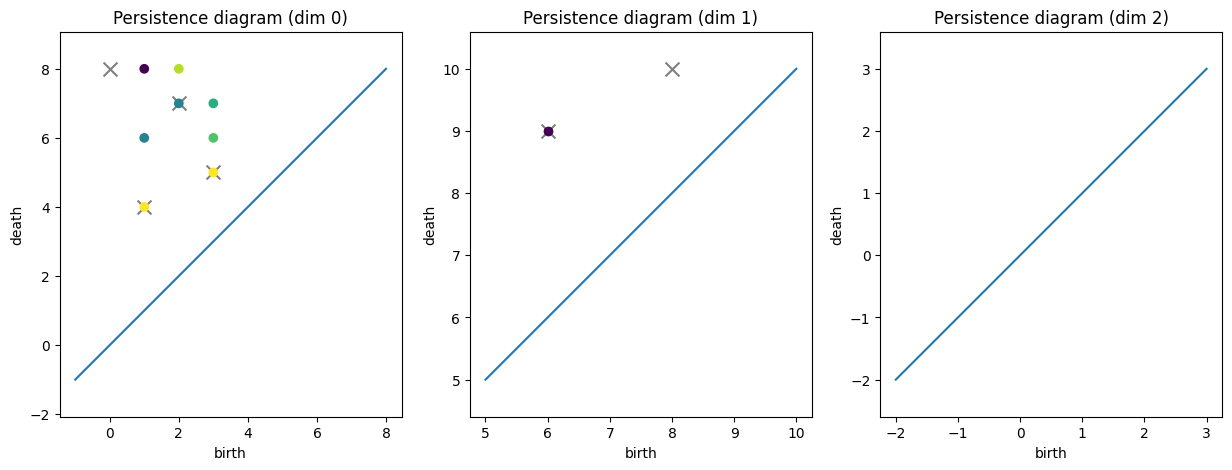

In [62]:
plot_diagram(f, eigenvalues, show=True, max_dim=2)

In [48]:
eigenvalues[0][2]

{0.0: array([], dtype=float64),
 1.0: array([], dtype=float64),
 2.0: array([], dtype=float64),
 3.0: array([], dtype=float64),
 4.0: array([0., 0., 0.]),
 5.0: array([0., 0., 0.]),
 6.0: array([0., 0., 0.]),
 7.0: array([ 1.00000000e+00,  8.62816615e-32, -5.60243672e-17]),
 8.0: array([ 1.80000000e+00, -5.89227699e-17, -5.89227699e-17]),
 9.0: array([], dtype=float64)}

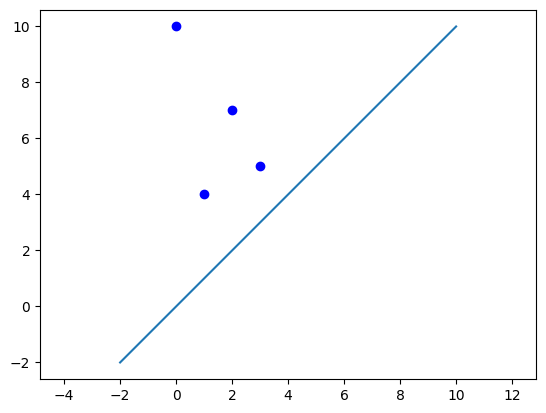

In [20]:
p = dio.cohomology_persistence(f, 47, True)
dgms = dio.init_diagrams(p, f)
dio.plot.plot_all_diagrams(dgms, show=True)

/tmp/ipykernel_91699/155483162.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(lambda t: landscape(t, dgm), 0, 20)


(45.499999999999964, 0.0002793851177784745)

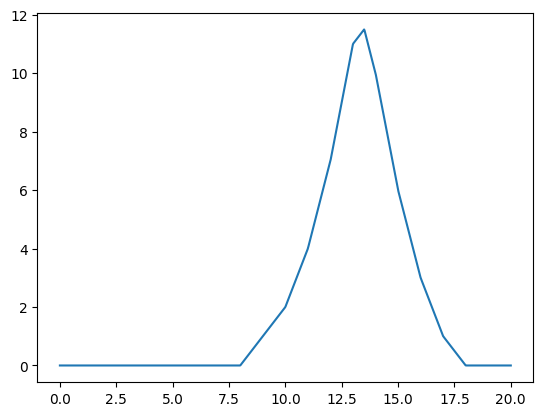

In [7]:
import scipy.integrate as integrate


def landscape(t, dgm):
    return np.sum([max(t-p.birth, 0) if t<(p.birth+p.death)/2 else max(p.death-t, 0) for p in dgm if p.death != np.inf])
p = dio.cohomology_persistence(f, 47, True)
dgms = dio.init_diagrams(p, f)
# dio.plot.plot_all_diagrams(dgms)

dgm = dgms[1]
t_axis = np.linspace(0, 20, 1000)
landscapes = np.array([landscape(t, dgm) for t in t_axis])
plt.plot(t_axis, landscapes)
integrate.quad(lambda t: landscape(t, dgm), 0, 20)

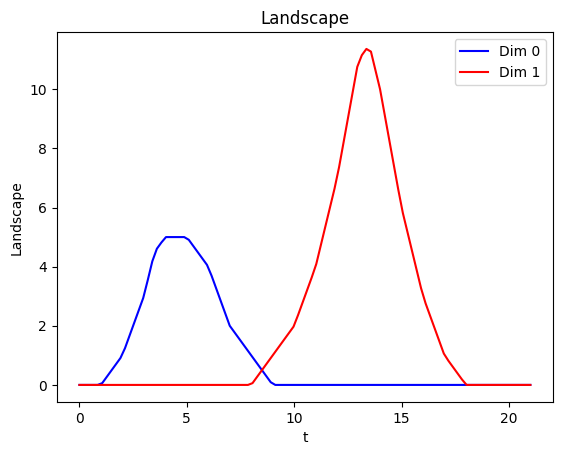

In [3]:
from landscapes import *

test_land = Landscape(f)
test_land.plot()

